In [1]:
import pandas as pd
import numpy as np
#from scipy.stats import uniform
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.inspection import permutation_importance

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [2]:
# this script takes in:
# - the position of the switch,
# - and the voltages V0 and V1
# to assess the health of the circuit. 

# The quantification of the health of the circuit may be dichotomous (up/down), but it may also take multiple states F1,...,Fn
# Therfore, this health assessment may be framed as a classification problem

In [3]:
# a set of training data consists of inputs (S, V0, V1) and outputs (Health, F1,...Fn)

In [4]:
def readfile(bestand):
    table = None
    table = pd.read_excel(bestand, index_col=0)
    
    table.loc[:,['S','V0','V1']] = table.loc[:,['S','V0','V1']].astype('float64', errors="ignore") #it appears that some Voltages came in as an integer and that sucks...
    table.loc[:,['F1','F2','F3','F4']] = table.loc[:,['F1','F2','F3','F4']].astype('bool', errors="ignore")
    
    table.loc[:,'Health'] = ~(table.loc[:,['F1','F2','F3','F4']]).any(axis='columns', bool_only=True)
    
    return table

In [5]:
def plotlabels(table, by, legendtitle, title):
    dum = table.groupby(by)[['S','V0','V1']]
    fig = plt.figure(figsize = (6,6))
    plt.rcParams['font.size']=14
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.set_xlabel('V0'), ax.set_ylabel('V1'),ax.set_zlabel('S')
    ax.set_xlim(0,5),    ax.set_ylim(0,5),   ax.set_zlim(0,1)
    ax.set_title(title)

    for i in dum.groups:
        du = dum.get_group(i)

        S = du.loc[:,'S']
        V0 = du.loc[:,'V0']
        V1 = du.loc[:,'V1']
        ax.scatter3D(V0,V1,S, zdir='z', color=np.random.rand(1,3), 
                     marker='v', 
                     label = str(i), 
                         s=V0.mean()*150+5)
    
    ax.legend(loc='right', bbox_to_anchor=(1.8, 0.8), title = legendtitle)
    ax.view_init(elev=25, azim=35)#, roll=0)
    
    return

In [6]:
# fit a RF model and determine gini importance

def selectRFmodel(XX,y):
    imputer = KNNImputer(n_neighbors=3, weights="distance")
    XX = imputer.fit_transform(XX)
    
    rfmodel = RandomForestClassifier(n_estimators = 40, criterion="gini",random_state = None)
    
    return rfmodel.fit(XX, y), rfmodel.feature_importances_

In [7]:
# find inertia of k means clustering

def get_inert(kk, XX):
    kmeanModel = KMeans(n_clusters=kk, n_init=10)
    kmeanModel.fit(XX)
    inert = kmeanModel.inertia_
    
    return inert, kmeanModel


In [8]:
# perform k means clustering while inertia reduction is sufficiently large

def vl_regime(XX):
    imputer = KNNImputer(n_neighbors=3, weights="distance")
    XX = imputer.fit_transform(XX)

    scaler=StandardScaler()                                  # transpose the dataframe while disposing the first non-numerical column
    Xtrans = scaler.fit_transform(XX)   
    
    k = 2
    INERT0, KMM0 = get_inert(1, Xtrans)
    INERT1, KMM1 = get_inert(2, Xtrans)

    while (INERT1/INERT0<0.8)&(INERT1>1):
        k = k + 1
        INERT0 = INERT1
        KMM0 = KMM1
        INERT1, KMM1 = get_inert(k, Xtrans)
    
    OOregime = KMM0.predict(Xtrans)                    # cluster the timeseries of vl
    OOcenters = scaler.inverse_transform( 
        pd.DataFrame(KMM0.cluster_centers_ ))          # infer cluster centers
        
    return scaler, KMM0, OOregime, OOcenters


In [9]:
#load the balanced and complete training data in a pandas dataframe

#df_bc = readfile("C:/Users/Admin/Pythonprojects/RAMS/data/Arduino_trainingset_BalancedComplete.xlsx")
df_bc = readfile("https://raw.githubusercontent.com/chrisrijsdijk/RAMS/master/data/Arduino_trainingset_BalancedComplete.xlsx")

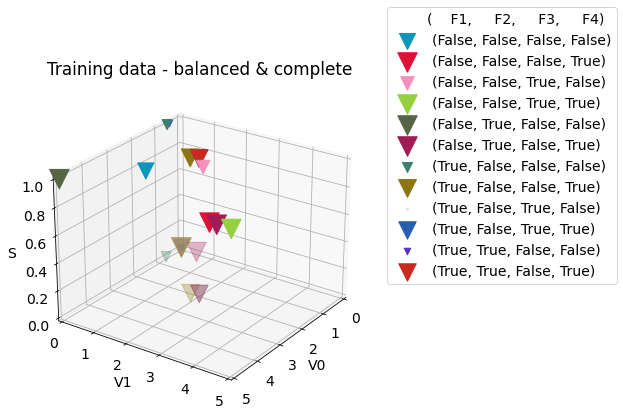

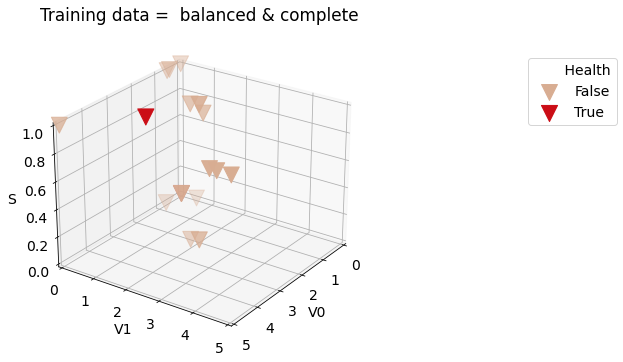

In [10]:
# plot the training data and their labels

plotlabels(df_bc,                                          # data frame
           ['F1','F2','F3','F4'],                          # specify the labels to groupby
          '      (    F1,     F2,     F3,     F4)',        # title of the legend
           'Training data - balanced & complete'           # title of graph
          )

plotlabels(df_bc,                                          # data frame
           ['Health'],                                     # specify the labels to groupby
          '       Health',                                 # title of the legend
           'Training data =  balanced & complete'          # title of graph
          )


In [11]:
plt.close('all')

In [12]:
#load the unbalanced and incomplete training data in a pandas dataframe

df = None

#df_ui =readfile("C:/Users/Admin/Pythonprojects/RAMS/data/Arduino_trainingset_UnbalancedIncomplete.xlsx")
df_ui = readfile("https://raw.githubusercontent.com/chrisrijsdijk/RAMS/master/data/Arduino_trainingset_UnbalancedIncomplete.xlsx")

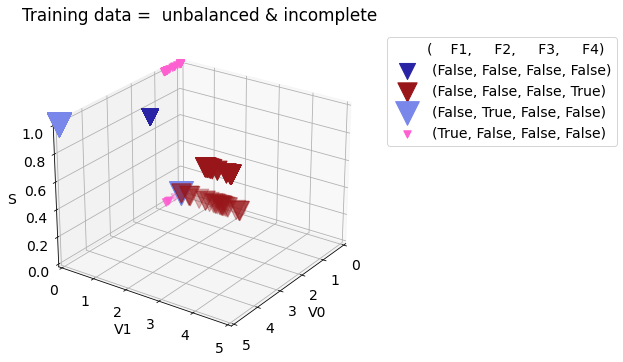

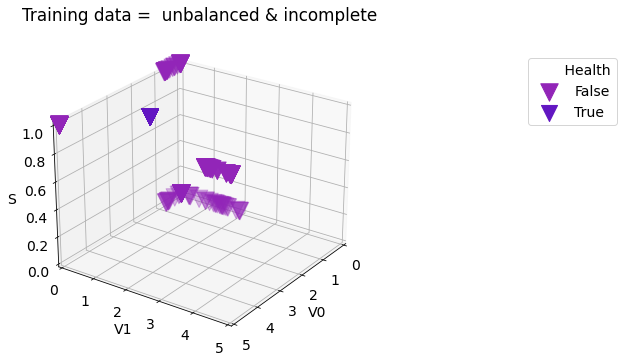

In [13]:
# plot the training data and their labels

plotlabels(df_ui,                                          # data frame
           ['F1','F2','F3','F4'],                          # specify the labels to groupby
          '      (    F1,     F2,     F3,     F4)',        # title of the legend
           'Training data =  unbalanced & incomplete'      # title of graph
          )

plotlabels(df_ui,                                          # data frame
           ['Health'],                                     # specify the labels to groupby
          '       Health',                                 # title of the legend
           'Training data =  unbalanced & incomplete'      # title of graph
          )


In [14]:
plt.close('all')

In [28]:
# infer RF models from df_bc data

X = df_bc.iloc[:,[0,1,2]]                    #define the explanatory variables
X_names = df_bc.iloc[:,[0,1,2]].columns      #load a string of column names to label the output of the random forest model afterwards...

rf_bc_f1_model, rf_bc_f1_featimp = selectRFmodel(X, np.array(df_bc["F1"].astype('float')))
rf_bc_f2_model, rf_bc_f2_featimp = selectRFmodel(X, np.array(df_bc["F2"].astype('float')))
rf_bc_f3_model, rf_bc_f3_featimp = selectRFmodel(X, np.array(df_bc["F3"].astype('float')))
rf_bc_f4_model, rf_bc_f4_featimp = selectRFmodel(X, np.array(df_bc["F4"].astype('float')))

rf_bc_health_model, rf_bc_health_featimp = selectRFmodel(X, np.array(df_bc["Health"].astype('float')))


In [29]:
# infer RF models from df_ui data

X = df_ui.iloc[:,[0,1,2]]                    #define the explanatory variables
X_names = df_ui.iloc[:,[0,1,2]].columns        #load a string of column names to label the output of the random forest model afterwards...

rf_ui_f1_model, rf_ui_f1_featimp = selectRFmodel(X, np.array(df_ui["F1"].astype('float')))
rf_ui_f2_model, rf_ui_f2_featimp = selectRFmodel(X, np.array(df_ui["F2"].astype('float')))
rf_ui_f3_model, rf_ui_f3_featimp = selectRFmodel(X, np.array(df_ui["F3"].astype('float')))
rf_ui_f4_model, rf_ui_f4_featimp = selectRFmodel(X, np.array(df_ui["F4"].astype('float')))

rf_ui_health_model, rf_ui_health_featimp = selectRFmodel(X, np.array(df_ui["Health"].astype('float')))


In [17]:
# plot the importance of the various explanatory variables using Gini importance
# Gini importance is a number between zero and one, the heigher the Gini importance the better the explanatory variable can predict the failure y 

featureImportances = np.array([rf_bc_f1_model.feature_importances_, 
                               rf_bc_f2_model.feature_importances_, 
                               rf_bc_f3_model.feature_importances_, 
                               rf_bc_f4_model.feature_importances_,
                               rf_bc_health_model.feature_importances_,
                               
                               rf_ui_f1_model.feature_importances_, 
                               rf_ui_f2_model.feature_importances_, 
                               rf_ui_f3_model.feature_importances_, 
                               rf_ui_f4_model.feature_importances_,
                               rf_ui_health_model.feature_importances_
                              ])

pd.DataFrame(featureImportances, columns = X_names, index = ["bc_F1","bc_F2","bc_F3","bc_F4","bc_Health",
                                                            "ui_F1","ui_F2","ui_F3","ui_F4","ui_Health"])

,S,V0,V1
bc_F1,0.128449,0.568984,0.302567
bc_F2,0.103192,0.390828,0.505980
bc_F3,0.107682,0.441964,0.450354
bc_F4,0.047873,0.374336,0.577791
bc_Health,0.084675,0.600626,0.314699
ui_F1,0.202207,0.638913,0.158880
ui_F2,0.033774,0.518948,0.447278
ui_F3,0.000000,0.000000,0.000000
ui_F4,0.029629,0.149301,0.821070
ui_Health,0.058939,0.414142,0.526919


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


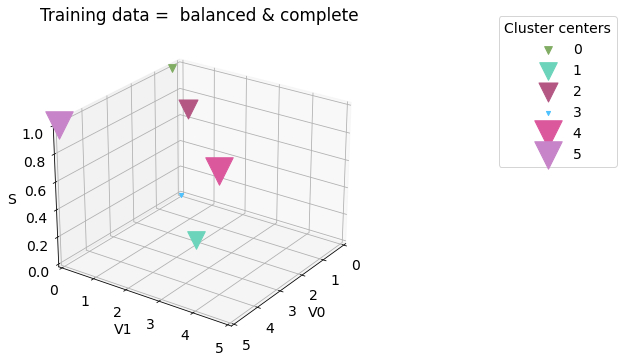

In [18]:
# infer KM model from df_bc data

X = df_bc.iloc[:,[0,1,2]]                    #define the explanatory variables
X_names = df_bc.iloc[:,[0,1,2]].columns      #load a string of column names to label the output of the random forest model afterwards...

df_bc_scaler, df_bc_KMM, df_bc_regime, df_bc_centers = vl_regime(X)

df_bc_cluster = pd.DataFrame(df_bc_centers, columns=X_names)
plotlabels(df_bc_cluster,                          # data frame
           list(df_bc_cluster.index),              # specify the labels to groupby
           'Cluster centers',                      # title of the legend
           'Training data =  balanced & complete'  # title of graph
          )

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


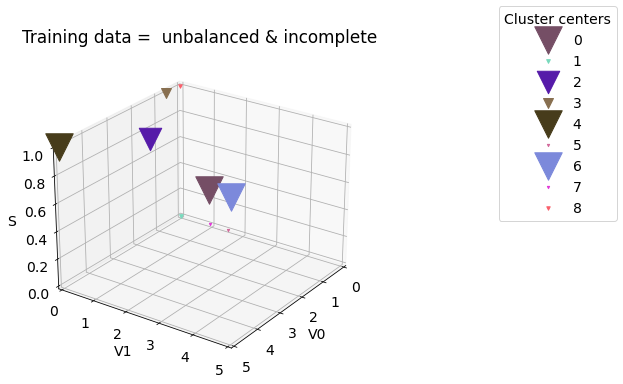

In [19]:
# infer KM model from df_ui data

X = df_ui.iloc[:,[0,1,2]]                    #define the explanatory variables
X_names = df_ui.iloc[:,[0,1,2]].columns      #load a string of column names to label the output of the random forest model afterwards...

df_ui_scaler, df_ui_KMM, df_ui_regime, df_ui_centers = vl_regime(X)

df_ui_cluster = pd.DataFrame(df_ui_centers, columns=X_names)
plotlabels(df_ui_cluster,                              # data frame
           list(df_ui_cluster.index),                  # specify the labels to groupby
           'Cluster centers',                           # title of the legend
           'Training data =  unbalanced & incomplete'  # title of graph
          )

In [20]:
#confront the various model with the validation data

In [21]:

df_val = None

# this data set represents the system during deployment
#df_val = readfile("C:/Users/Admin/Pythonprojects/RAMS/data/Arduino_validationset.xlsx")
df_val = readfile("https://raw.githubusercontent.com/chrisrijsdijk/RAMS/master/data/Arduino_validationset.xlsx")


In [22]:
# fit assess data to some k_means cluster

def fitKMeans(scaler, model, data):
    datatrans = scaler.transform(data)
    clusterlabel = model.predict(datatrans)
    clustercentertrans = model.cluster_centers_[clusterlabel]
    clustercenter = scaler.inverse_transform(clustercentertrans)
    distance = np.linalg.norm(data-clustercenter)
    
    return np.array([distance])
    

In [23]:
# infer conclusions from the data using the various RF and KM models

df_bc_distance = {}
df_ui_distance = {}

rf_bc_f1 = {}
rf_bc_f2 = {}
rf_bc_f3 = {}
rf_bc_f4 = {}
rf_bc_health = {}

rf_ui_f1 = {}
rf_ui_f2 = {}
rf_ui_f3 = {}
rf_ui_f4 = {}
rf_ui_health = {}

for i in df_val.index:
    dummy = df_val.loc[i,:]
    dum5 = np.array([ dummy[:3] ])
    df_bc_distance[i] = fitKMeans(df_bc_scaler, df_bc_KMM, dum5)
    df_ui_distance[i] = fitKMeans(df_ui_scaler, df_ui_KMM, dum5)
    
    rf_bc_f1[i] = rf_bc_f1_model.predict(dum5)
    rf_bc_f2[i] = rf_bc_f2_model.predict(dum5)
    rf_bc_f3[i] = rf_bc_f3_model.predict(dum5)
    rf_bc_f4[i] = rf_bc_f4_model.predict(dum5)
    rf_bc_health[i] = rf_bc_health_model.predict(dum5)
    
    rf_ui_f1[i] = rf_ui_f1_model.predict(dum5)
    rf_ui_f2[i] = rf_ui_f2_model.predict(dum5)
    rf_ui_f3[i] = rf_ui_f3_model.predict(dum5)
    rf_ui_f4[i] = rf_ui_f4_model.predict(dum5)
    rf_ui_health[i] = rf_ui_health_model.predict(dum5)
    

In [30]:
# just dump the result in an Excel file for those who want

val_result = pd.concat( [df_val, 
                         pd.DataFrame(df_bc_distance, index=['bc_cluster']).T,
                         pd.DataFrame(df_ui_distance, index=['ui_cluster']).T,
                         pd.DataFrame(rf_bc_f1, index=['F1_rf_bc']).T.astype('bool'), 
                         pd.DataFrame(rf_bc_f2, index=['F2_rf_bc']).T.astype('bool'), 
                         pd.DataFrame(rf_bc_f3, index=['F3_rf_bc']).T.astype('bool'), 
                         pd.DataFrame(rf_bc_f4, index=['F4_rf_bc']).T.astype('bool'), 
                         pd.DataFrame(rf_bc_health, index=['Health_rf_bc']).T.astype('bool'), 
    
                         pd.DataFrame(rf_ui_f1, index=['F1_rf_ui']).T.astype('bool'), 
                         pd.DataFrame(rf_ui_f2, index=['F2_rf_ui']).T.astype('bool'), 
                         pd.DataFrame(rf_ui_f3, index=['F3_rf_ui']).T.astype('bool'), 
                         pd.DataFrame(rf_ui_f4, index=['F4_rf_ui']).T.astype('bool'), 
                         pd.DataFrame(rf_ui_health, index=['Health_rf_ui']).T.astype('bool')], 
    
                       axis=1 )

In [37]:
#val_result.to_excel("kanweg.xlsx")

In [32]:
val_result.groupby(['F1_rf_bc','F2_rf_bc','F3_rf_bc','F4_rf_bc'])[['S','V0','V1']].mean().reset_index()

,F1_rf_bc,F2_rf_bc,F3_rf_bc,F4_rf_bc,S,V0,V1
0,False,False,False,False,0.248201,0.833960,0.368266
1,False,False,False,True,0.913043,4.560759,4.120669
2,False,False,True,False,1.000000,2.358141,2.356343
3,False,True,False,False,1.000000,4.995117,0.000000
4,False,True,False,True,0.000000,0.000000,0.411784
5,True,False,False,False,0.222222,0.542806,0.000000
6,True,False,True,False,1.000000,0.131836,0.000000
7,True,True,False,False,1.000000,0.465199,0.000000


In [27]:
val_result.groupby(['F1_rf_ui','F2_rf_ui','F3_rf_ui','F4_rf_ui'])[['S','V0','V1']].mean().reset_index()

,F1_rf_ui,F2_rf_ui,F3_rf_ui,F4_rf_ui,S,V0,V1
0,False,False,False,False,0.310954,0.971800,0.519183
1,False,False,False,True,0.777778,3.885091,3.564091
2,False,True,False,False,1.000000,4.995117,0.000000
3,True,False,False,False,0.414286,0.394322,0.000000


In [36]:
val_result.groupby(['F1','F2','F3','F4'])[['S','V0','V1']].mean().reset_index()

,F1,F2,F3,F4,S,V0,V1
0,False,False,False,False,0.385475,1.286116,0.570716
1,False,False,False,True,0.355932,1.777923,1.631025
2,False,False,True,False,0.441860,1.041969,1.041175
3,False,True,False,False,0.500000,2.497559,0.000000
4,True,False,False,False,0.414286,0.394322,0.000000


In [33]:
val_result.groupby(['Health_rf_bc'])[['S','V0','V1']].mean().reset_index()

,Health_rf_bc,S,V0,V1
0,False,0.288235,0.947538,0.414709
1,True,1.000000,3.336447,1.480554


In [34]:
val_result.groupby(['Health_rf_ui'])[['S','V0','V1']].mean().reset_index()

,Health_rf_ui,S,V0,V1
0,False,0.626984,2.201257,0.763734
1,True,0.310954,0.971800,0.519183


In [35]:
val_result.groupby(['Health'])[['S','V0','V1']].mean().reset_index()

,Health,S,V0,V1
0,False,0.426087,1.400709,0.613048
1,True,0.385475,1.286116,0.570716
